In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualize MNIST Digits from train.csv

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


file_path = "/content/drive/My Drive/GAN_for_MNIST/train.csv"
df = pd.read_csv(file_path)
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Showing digit at index 0 with label 1


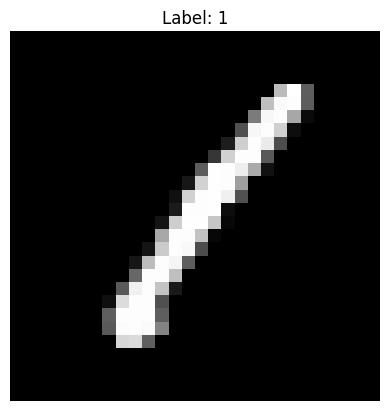

Showing digit at index 1 with label 0


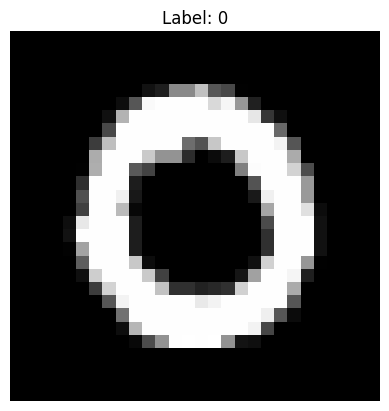

Showing digit at index 2 with label 1


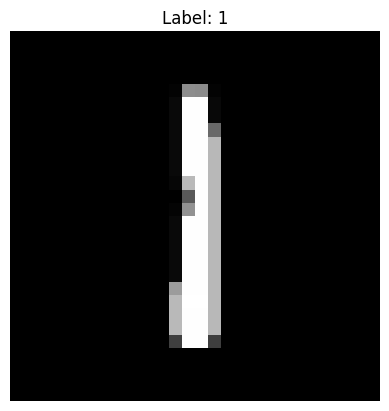

Showing digit at index 3 with label 4


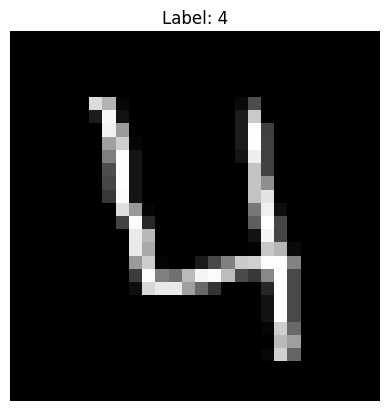

Showing digit at index 4 with label 0


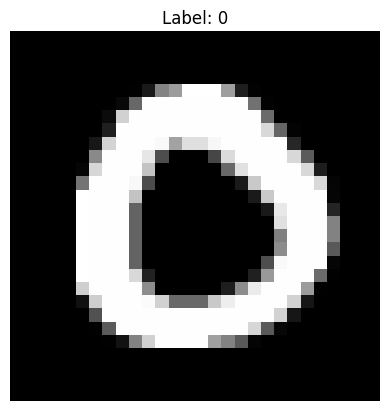

Showing digit at index 5 with label 0


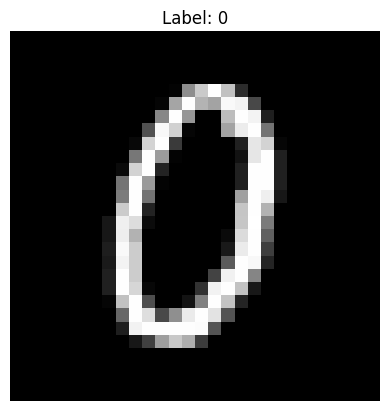

Showing digit at index 6 with label 7


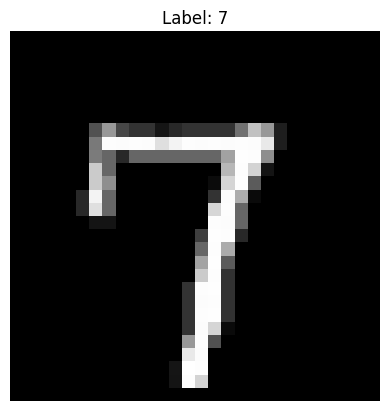

Showing digit at index 7 with label 3


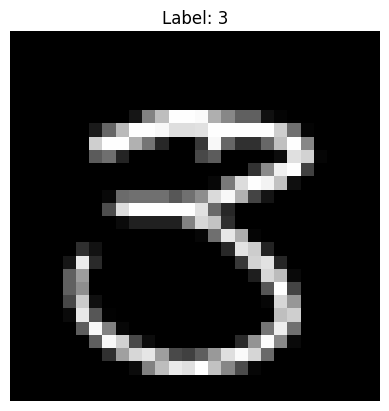

Showing digit at index 8 with label 5


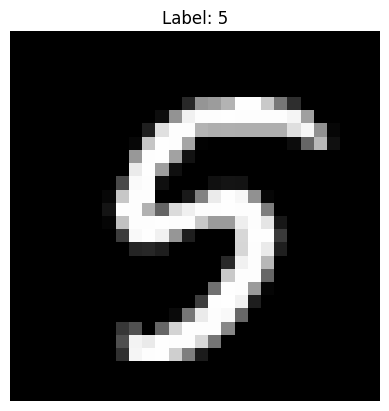

Showing digit at index 9 with label 3


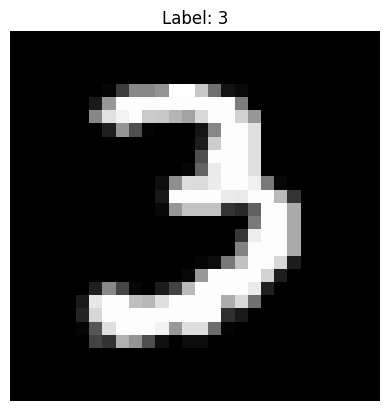

In [ ]:
# Separate labels and images
labels = df['label'].values
images = df.drop('label', axis=1).values
# print("Labels dtype:", labels.dtype)
# print("Images dtype:", images.dtype)
# print(labels.shape)
# print(images.shape)
# print("Images dtype:", images.dtype)



# Visualize a digit
def show_digit(index):
    digit_image = images[index].reshape(28, 28)
    plt.imshow(digit_image, cmap='gray')
    plt.title(f"Label: {labels[index]}")
    plt.axis('off')
    plt.show()

# Show the first 10 digits
for i in range(10):
    print(f"Showing digit at index {i} with label {labels[i]}")
    show_digit(i)


# Build the GAN (Generator + Discriminator)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#define generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()  # Output pixel values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        return img

#define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


# Prepare Dataset for GAN Training

1.Normalize pixel values from [0, 255] → [-1, 1] (to match tanh() output in Generator)

2.Convert images and labels to torch.Tensor

3.Create a PyTorch DataLoader to iterate during training



In [ ]:
#preprocess and create dataloader

import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Normalize pixel values to [-1, 1]
images_norm = (images / 255.0) * 2 - 1  # from [0, 255] to [-1, 1]

# Step 2: Convert to torch tensors
images_tensor = torch.tensor(images_norm, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Step 3: Create dataset and dataloader
dataset = TensorDataset(images_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("DataLoader ready.")


DataLoader ready.


# Train the GAN on MNIST

The Generator learns to create fake digits from random noise (z)

The Discriminator learns to detect whether an image is real (from MNIST) or fake (from Generator)

Both networks compete and improve over time

In [ ]:
# Initialize models
latent_dim = 100
generator = Generator(latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)




In [ ]:
import numpy as np

epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G_losses, D_losses = [], []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.view(batch_size, -1).to(device)

        # Ground truth labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Log losses
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    print(f"Epoch {epoch+1}/{epochs} | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")


Epoch 1/50 | Generator Loss: 4.4545 | Discriminator Loss: 0.0108
Epoch 2/50 | Generator Loss: 3.9010 | Discriminator Loss: 0.1218
Epoch 3/50 | Generator Loss: 4.6296 | Discriminator Loss: 0.0686
Epoch 4/50 | Generator Loss: 6.6099 | Discriminator Loss: 0.0408
Epoch 5/50 | Generator Loss: 6.2358 | Discriminator Loss: 0.0404
Epoch 6/50 | Generator Loss: 5.8974 | Discriminator Loss: 0.1621
Epoch 7/50 | Generator Loss: 5.4166 | Discriminator Loss: 0.0967
Epoch 8/50 | Generator Loss: 4.0962 | Discriminator Loss: 0.1178
Epoch 9/50 | Generator Loss: 4.6562 | Discriminator Loss: 0.0518
Epoch 10/50 | Generator Loss: 4.7826 | Discriminator Loss: 0.3144
Epoch 11/50 | Generator Loss: 3.8508 | Discriminator Loss: 0.1078
Epoch 12/50 | Generator Loss: 3.0143 | Discriminator Loss: 0.0908
Epoch 13/50 | Generator Loss: 5.0691 | Discriminator Loss: 0.4413
Epoch 14/50 | Generator Loss: 3.7123 | Discriminator Loss: 0.3377
Epoch 15/50 | Generator Loss: 3.7583 | Discriminator Loss: 0.1867
Epoch 16/50 | Gener

In [ ]:
import pickle

drive_path = "/content/drive/My Drive/GAN_for_MNIST/"

# Save Generator
with open(drive_path + "G.pkl", "wb") as f:
    pickle.dump(generator.state_dict(), f)

# Save Discriminator
with open(drive_path + "D.pkl", "wb") as f:
    pickle.dump(discriminator.state_dict(), f)


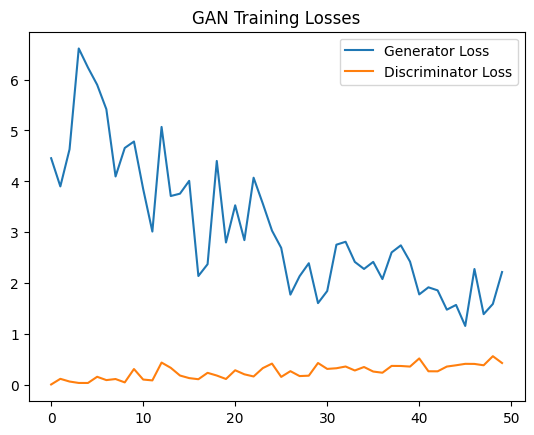

In [ ]:
#loss curve
import matplotlib.pyplot as plt

plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.legend()
plt.title("GAN Training Losses")
plt.show()


# Generate & Display 100 Fake Digits (10×10 Grid)

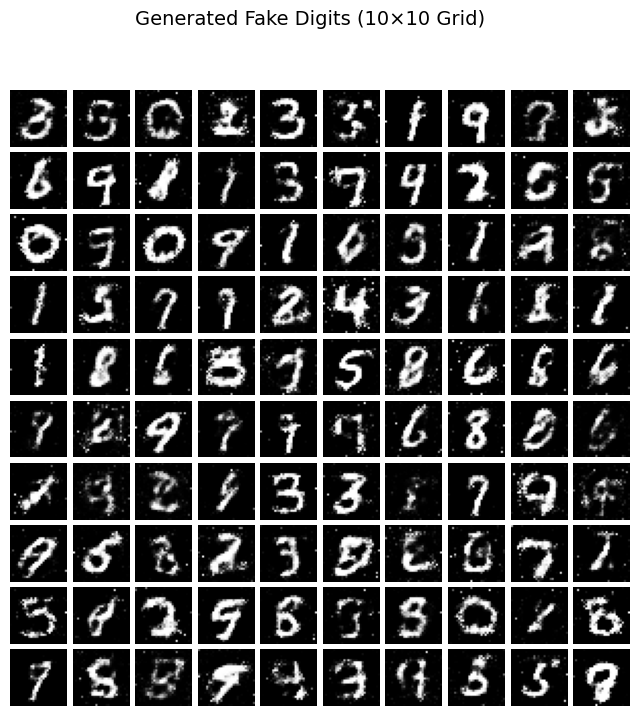

In [ ]:
import matplotlib.pyplot as plt

# Ensure generator is in eval mode and on correct device
generator.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate 100 latent vectors
z = torch.randn(100, latent_dim).to(device)

# Generate fake images
with torch.no_grad():
    fake_imgs = generator(z).cpu().view(-1, 28, 28)  # reshape to (100, 28, 28)

# Plot in 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fake_imgs[i * 10 + j], cmap='gray')
        axs[i, j].axis('off')

plt.suptitle("Generated Fake Digits (10×10 Grid)", fontsize=14)
plt.show()


Seems many digits are unclear for human to identify. So lets create more than 100 (500 digits) and pick clear 100 digits only.

In [ ]:
#generate 500 samples

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Create output folder
save_path = "/content/drive/My Drive/GAN_for_MNIST/Fake_Digits"
os.makedirs(save_path, exist_ok=True)

# Generate 500 latent vectors
num_samples = 500
z_vectors = torch.randn(num_samples, latent_dim).to(device)

# Generate images
generator.eval()
with torch.no_grad():
    generated_imgs = generator(z_vectors).cpu().view(-1, 28, 28)


In [ ]:
#review in batches of 10
def view_batch(start_idx):
    fig, axs = plt.subplots(1, 10, figsize=(12, 2))
    for i in range(10):
        img = generated_imgs[start_idx + i]
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"ID {start_idx + i}")
    plt.show()


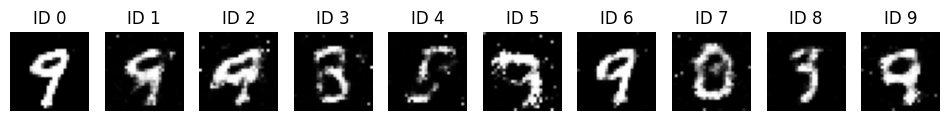

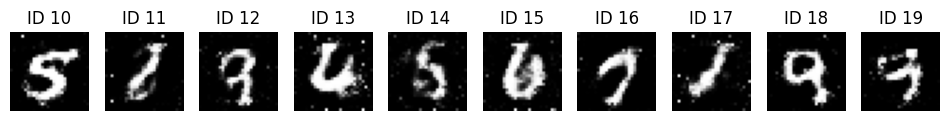

In [ ]:
view_batch(0)   # Shows images 0–9
view_batch(10)   # Shows images 10–19

Showing images 0 to 9


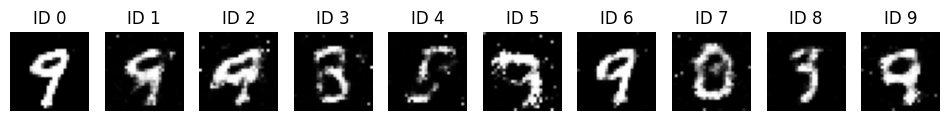

Showing images 10 to 19


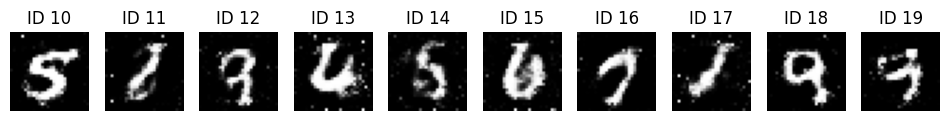

Showing images 20 to 29


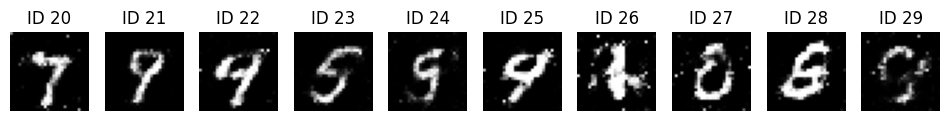

Showing images 30 to 39


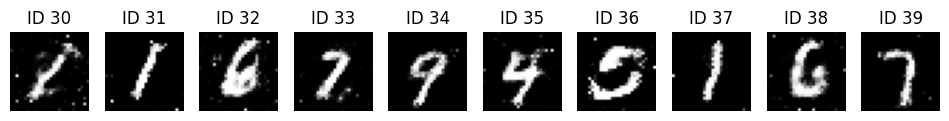

Showing images 40 to 49


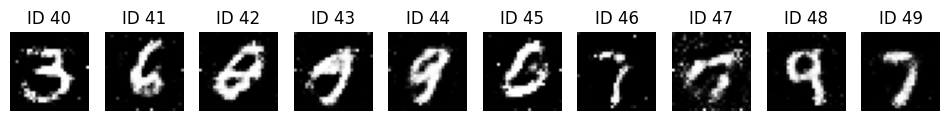

Showing images 50 to 59


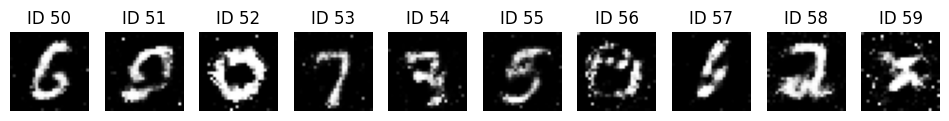

Showing images 60 to 69


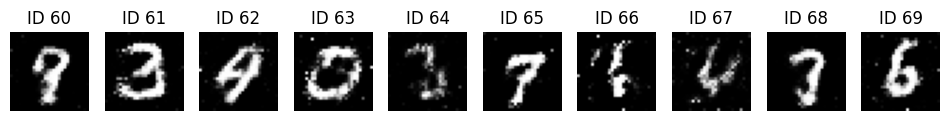

Showing images 70 to 79


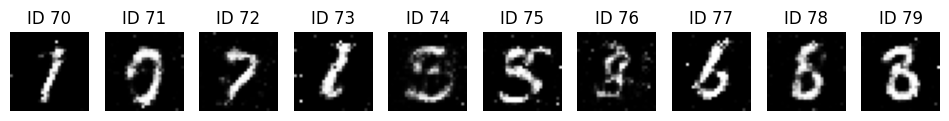

Showing images 80 to 89


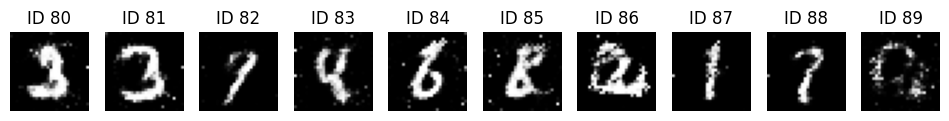

Showing images 90 to 99


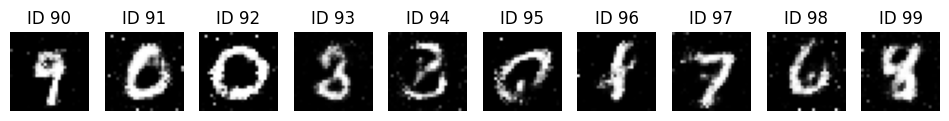

Showing images 100 to 109


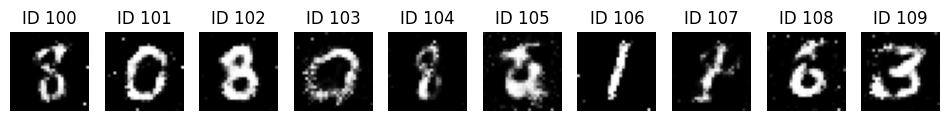

Showing images 110 to 119


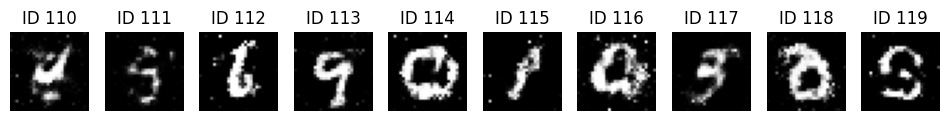

Showing images 120 to 129


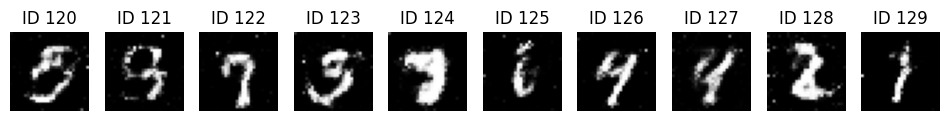

Showing images 130 to 139


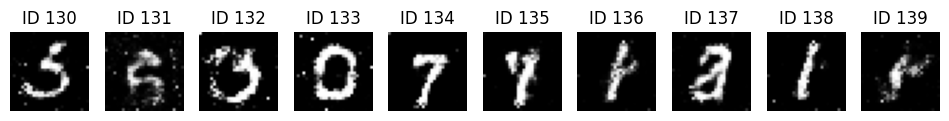

Showing images 140 to 149


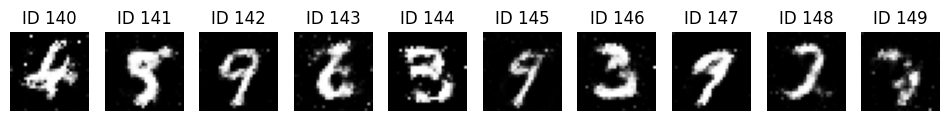

Showing images 150 to 159


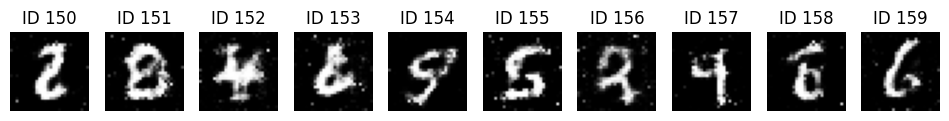

Showing images 160 to 169


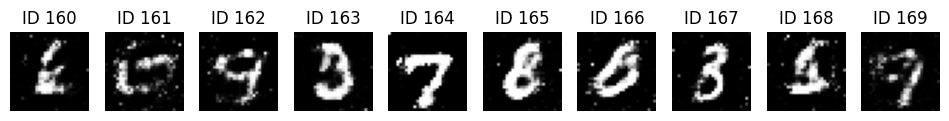

Showing images 170 to 179


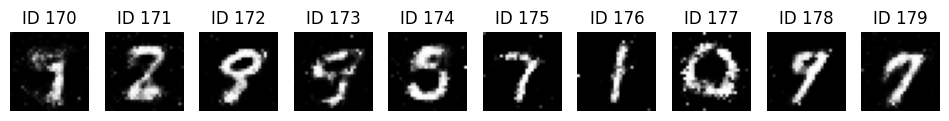

Showing images 180 to 189


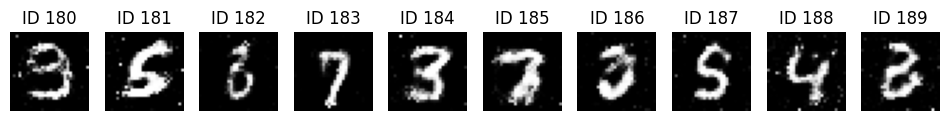

Showing images 190 to 199


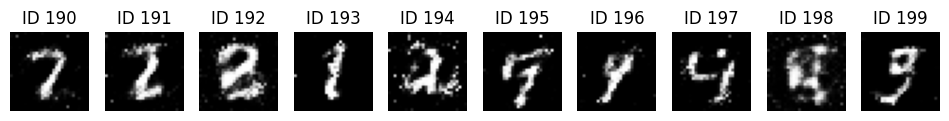

Showing images 200 to 209


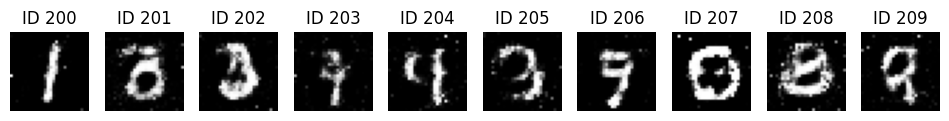

Showing images 210 to 219


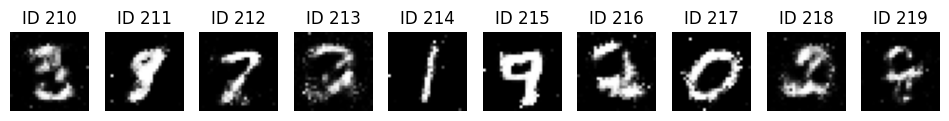

Showing images 220 to 229


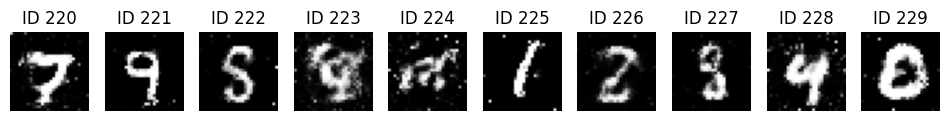

Showing images 230 to 239


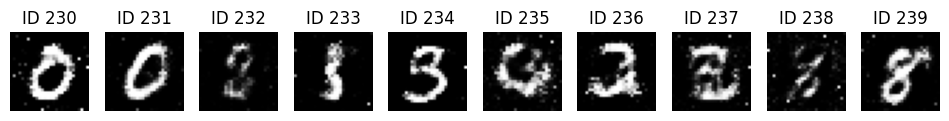

Showing images 240 to 249


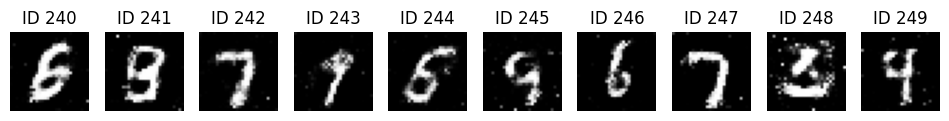

Showing images 250 to 259


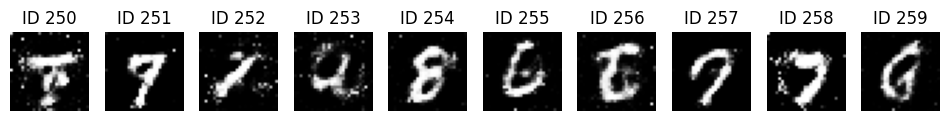

Showing images 260 to 269


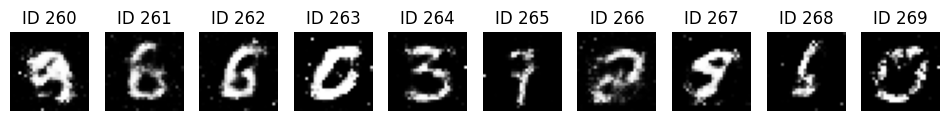

Showing images 270 to 279


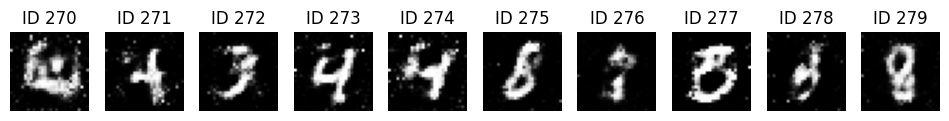

Showing images 280 to 289


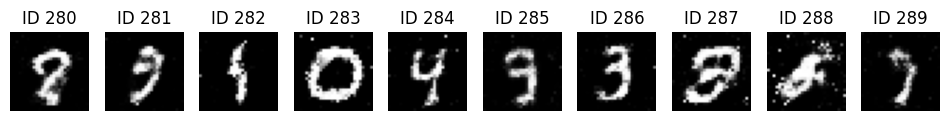

Showing images 290 to 299


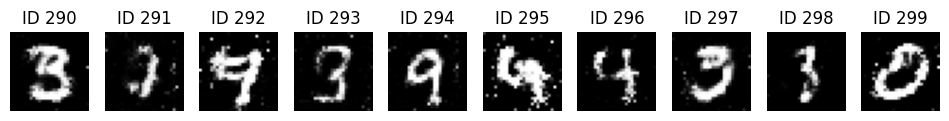

Showing images 300 to 309


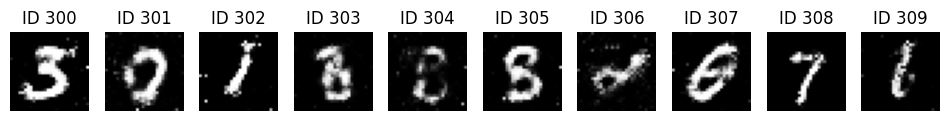

Showing images 310 to 319


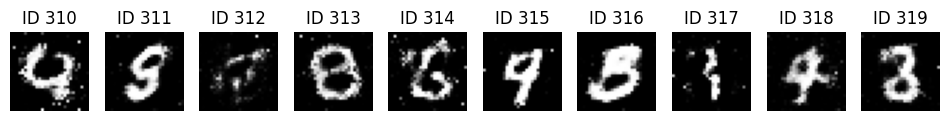

Showing images 320 to 329


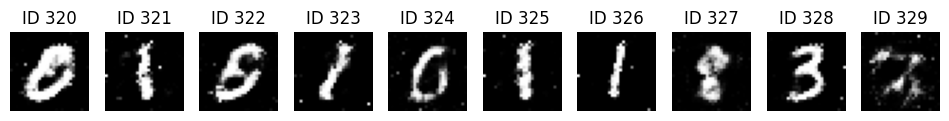

Showing images 330 to 339


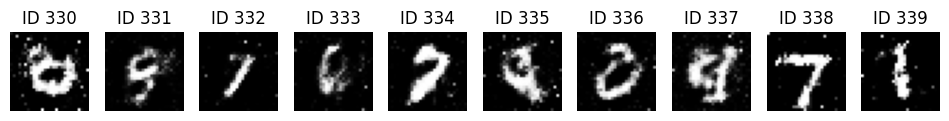

Showing images 340 to 349


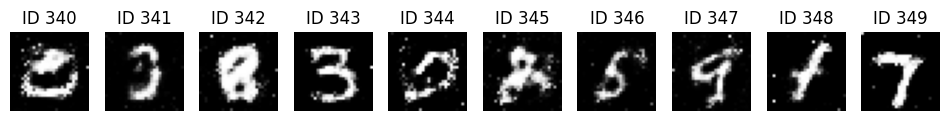

Showing images 350 to 359


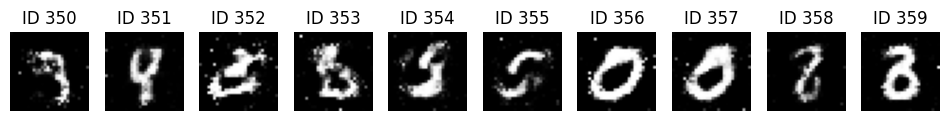

Showing images 360 to 369


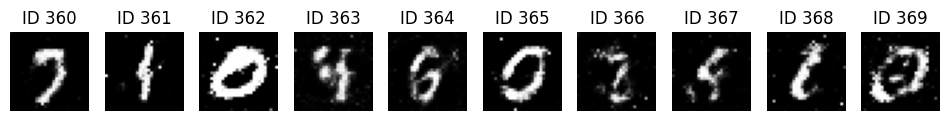

Showing images 370 to 379


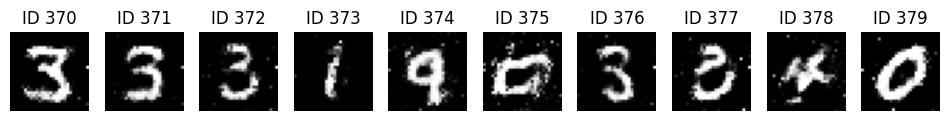

Showing images 380 to 389


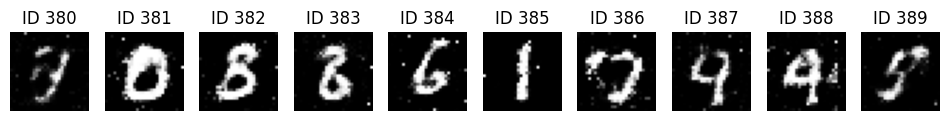

Showing images 390 to 399


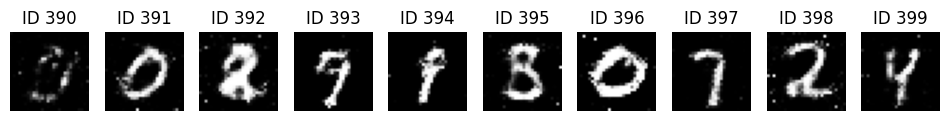

Showing images 400 to 409


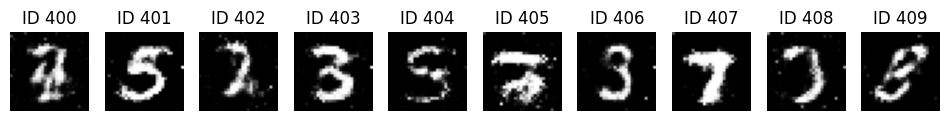

Showing images 410 to 419


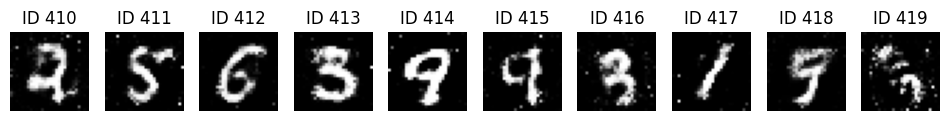

Showing images 420 to 429


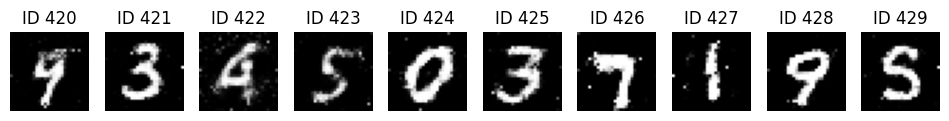

Showing images 430 to 439


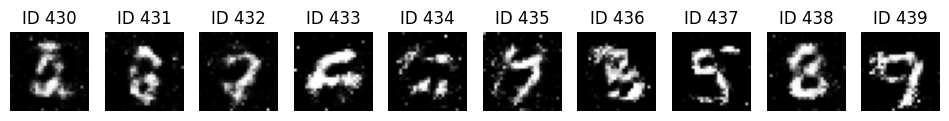

Showing images 440 to 449


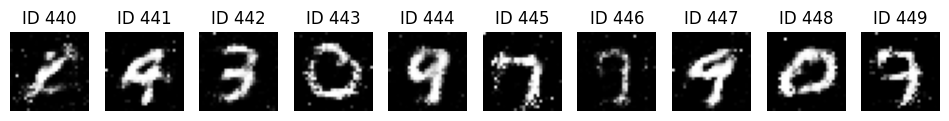

Showing images 450 to 459


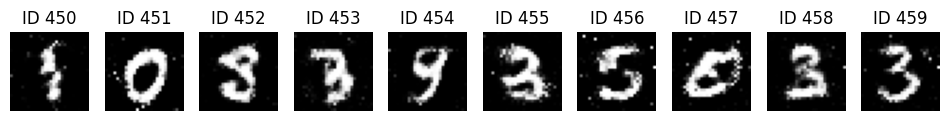

Showing images 460 to 469


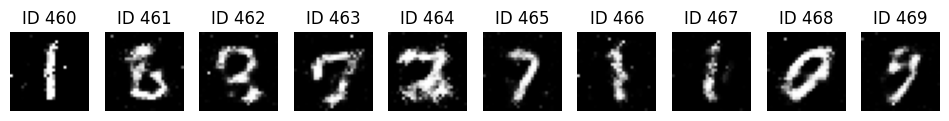

Showing images 470 to 479


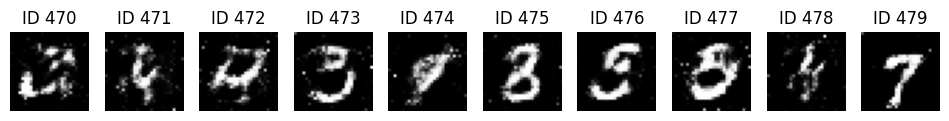

Showing images 480 to 489


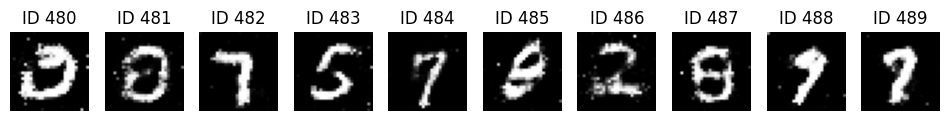

Showing images 490 to 499


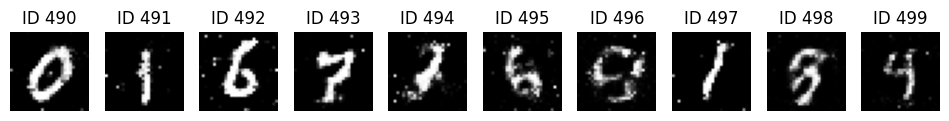

In [ ]:
for start in range(0, 500, 10):
    print(f"Showing images {start} to {start+9}")
    view_batch(start)


In [ ]:
#Save Selected Good Samples with Auto-Tracking


import os
from PIL import Image
import numpy as np
# Save location in Drive
save_path = "/content/drive/My Drive/GAN_for_MNIST/Fake_Digits"
os.makedirs(save_path, exist_ok=True)
# Track number of saved digits per label
label_counts = {str(i): 0 for i in range(10)}

#fnction to save good examples
def save_sample(index, label):
    label = str(label)
    count = label_counts[label]  # get current count for this label

    # Prepare folder
    label_dir = os.path.join(save_path, label)
    os.makedirs(label_dir, exist_ok=True)

    # File name
    filename = f"{count:03d}"

    # Save image (convert from [-1,1] to [0,255])
    img_array = (generated_imgs[index].numpy() * 127.5 + 127.5).astype(np.uint8)
    img_pil = Image.fromarray(img_array)
    img_pil.save(f"{label_dir}/{filename}.png")

    # Save latent vector z
    z_np = z_vectors[index].cpu().numpy()
    with open(f"{label_dir}/{filename}.txt", "w") as f:
        for val in z_np:
            f.write(f"{val}\n")

    label_counts[label] += 1  # increment count
    print(f"✅ Saved: {label}/{filename}.png and .txt")




In [ ]:
# List of (index, label) pairs. Considered the 1st 200 images generated.
pairs = [
    (128, 2), (150, 2), (156, 2), (4, 5), (6, 9), (7, 0), (8, 3), (9, 9), (10, 5),
    (13, 4), (14, 5), (16, 7), (17, 1), (18, 9), (19, 9), (20, 7), (22, 9), (23, 5), (24, 9), (25, 9),
    (26, 4), (27, 0), (28, 6), (31, 1), (32, 6), (33, 7), (34, 9), (35, 4), (36, 5), (37, 1), (38, 6), (39, 7),
    (40, 3), (41, 6), (44, 9), (45, 6), (46, 7), (48, 9), (49, 7), (50, 6), (52, 0), (53, 7), (54, 3),
    (55, 5), (56, 0), (57, 6), (58, 2), (61, 3), (62, 4), (63, 0), (64, 3), (65, 7), (68, 3), (69, 6),
    (70, 1), (72, 7), (73, 1), (74, 5), (75, 5), (77, 6), (78, 6), (79, 8), (80, 3), (81, 3), (82, 7),
    (83, 4), (84, 6), (85, 8), (87, 1), (88, 7), (90, 9), (91, 0), (92, 0), (93, 3), (94, 3), (95, 0),
    (96, 4), (97, 7), (98, 6), (99, 8), (100, 8), (101, 0), (102, 8), (103, 0), (104, 8), (106, 1),
    (108, 6), (109, 3), (111, 5), (112, 6), (113, 9), (114, 0), (115, 1), (116, 0), (117, 3), (118, 0),
    (119, 5), (120, 5), (121, 5), (122, 7)
]


for index, label in pairs:
    save_sample(index=index, label=label)




In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

# Path to your saved fake digits folder
base_path = "/content/drive/My Drive/GAN_for_MNIST/Fake_Digits"

# Collect all PNG image file paths
image_paths = glob.glob(os.path.join(base_path, "*", "*.png"))
# Sort by folder and file name (e.g., 0/000.png, 0/001.png, ..., 9/009.png)
image_paths = sorted(image_paths)
# Only use the first 100
image_paths = image_paths[:100]
# Create 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        img = Image.open(image_paths[idx])
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
# Save grid image
grid_output_path = "/content/drive/My Drive/GAN_for_MNIST/fakeimage_grid.png"
plt.savefig(grid_output_path, bbox_inches='tight', pad_inches=0.2)
plt.close()

print(f"Grid of 100 saved fake digits saved to: {grid_output_path}")


Grid of 100 saved fake digits saved to: /content/drive/My Drive/GAN_for_MNIST/fakeimage_grid.png


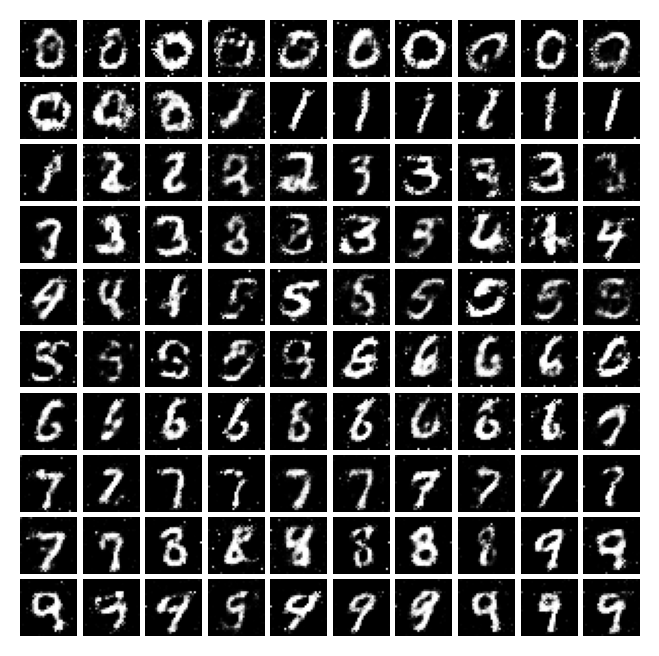

In [ ]:
from IPython.display import Image, display

# Path to the saved grid image
grid_path = "/content/drive/My Drive/GAN_for_MNIST/fakeimage_grid.png"
# Display the image
display(Image(filename=grid_path))


# Build and Train the Classifier

Build a CNN classifier (C) trained on real MNIST

Save it as C.pkl

Evaluate:

Accuracy on full MNIST test set

Classification error on:

S0 → 100 real MNIST test images

S1 → 100 fake digit images from Fake_Digits/

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Normalize to [-1, 1] to match GAN preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # from [0,1] to [-1,1]
])

# Download training and test datasets
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]


This model will:

Be trained on real MNIST training data

Be tested on:

The full MNIST test set

S0 (real 100 samples)

S1 (100 fake images)



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#train the CNN on MNIST
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Accuracy: {acc:.2f}%")


Epoch 1/5 - Loss: 142.9428 - Accuracy: 95.36%
Epoch 2/5 - Loss: 40.9160 - Accuracy: 98.67%
Epoch 3/5 - Loss: 28.1035 - Accuracy: 99.04%
Epoch 4/5 - Loss: 21.0026 - Accuracy: 99.27%
Epoch 5/5 - Loss: 15.6487 - Accuracy: 99.44%


In [ ]:
# Evaluate classifier on full MNIST test set
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Testing Accuracy on MNIST Test Set: {test_accuracy:.2f}%")


Testing Accuracy on MNIST Test Set: 98.98%


# S0,S1 evaluation

In [ ]:
import torch
import random
import glob
import os
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

# Use the same transform as training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load MNIST test set
from torchvision.datasets import MNIST
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# 🔹 S0: 100 real MNIST test samples
random.seed(42)
s0_indices = random.sample(range(len(test_set)), 100)
s0_subset = Subset(test_set, s0_indices)
s0_loader = DataLoader(s0_subset, batch_size=100, shuffle=False)

# 🔎 Evaluate on S0
correct = 0
total = 0
classifier.eval()

with torch.no_grad():
    for images, labels in s0_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

s0_error = 100 - (100 * correct / total)
print(f"Classification error on S0 (real MNIST): {s0_error:.2f}%")

# 🔹 S1: 100 fake digit images with labels from folder structure
fake_path = "/content/drive/My Drive/GAN_for_MNIST/Fake_Digits"
s1_image_paths = sorted(glob.glob(os.path.join(fake_path, "*", "*.png")))[:100]

s1_images = []
s1_labels = []

for img_path in s1_image_paths:
    label = int(os.path.basename(os.path.dirname(img_path)))  # folder name is the label
    img = Image.open(img_path).convert("L")
    img = ToTensor()(img)
    img = transforms.Normalize((0.5,), (0.5,))(img)
    s1_images.append(img)
    s1_labels.append(label)

s1_tensor = torch.stack(s1_images).to(device)
s1_true_labels = torch.tensor(s1_labels).to(device)

# 🔎 Evaluate on S1
classifier.eval()
with torch.no_grad():
    outputs = classifier(s1_tensor)
    _, predicted = outputs.max(1)
    correct = predicted.eq(s1_true_labels).sum().item()
    total = s1_true_labels.size(0)

s1_error = 100 - (100 * correct / total)
print(f"Classification error on S1 (fake images): {s1_error:.2f}%")


Classification error on S0 (real MNIST): 0.00%
Classification error on S1 (fake images): 18.00%


While the classifier performed flawlessly on real MNIST data, it showed an 18% error rate on the generated samples. This suggests that although the Generator creates visually convincing digits, subtle differences still exist that the classifier picks up on.

Can conclude:

Classifier is reliable

Generator is good, but not perfect

Fake images are realistic enough to fool the classifier 82% of the time

In [ ]:

#save the classifier
save_path = "/content/drive/My Drive/GAN_for_MNIST/C.pkl"
with open(save_path, "wb") as f:
    pickle.dump(classifier.state_dict(), f)

print("Classifier saved as C.pkl in Drive.")


Classifier saved as C.pkl in Drive.
